<a href="https://colab.research.google.com/github/MahdiTheGreat/Financial-Instrument-sentiment-Analysis/blob/main/Auto_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima yfinance backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 8.5 MB/s eta 0:00:00


In [38]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
import os
import warnings

1. North America
a. S&P 500 (United States)

    Description: Tracks the performance of 500 large-cap U.S. companies.

    ETF:

        SPDR S&P 500 ETF Trust (SPY)

        iShares Core S&P 500 ETF (IVV)

        Vanguard S&P 500 ETF (VOO)

b. NASDAQ-100 (United States)

    Description: Tracks the performance of 100 of the largest non-financial companies listed on the NASDAQ.

    ETF:

        Invesco QQQ Trust (QQQ)

        Invesco NASDAQ 100 ETF (QQQM)

c. Dow Jones Industrial Average (DJIA) (United States)

    Description: Tracks 30 large, publicly-owned companies in the U.S.

    ETF:

        SPDR Dow Jones Industrial Average ETF (DIA)

d. S&P/TSX Composite (Canada)

    Description: Tracks the performance of the largest companies listed on the Toronto Stock Exchange.

    ETF:

        iShares S&P/TSX Capped Composite Index ETF (XIC)

        BMO S&P/TSX Capped Composite Index ETF (ZCN)

2. Europe
a. FTSE 100 (United Kingdom)

    Description: Tracks the 100 largest companies listed on the London Stock Exchange.

    ETF:

        iShares Core FTSE 100 ETF (ISF)

        Vanguard FTSE 100 UCITS ETF (VUKE)

b. DAX (Germany)

    Description: Tracks the performance of the 40 largest companies listed on the Frankfurt Stock Exchange.

    ETF:

        iShares DAX UCITS ETF (EXS1)

        Xtrackers DAX UCITS ETF (DBXD)

c. CAC 40 (France)

    Description: Tracks the performance of the 40 largest companies listed on the Euronext Paris.

    ETF:

        Amundi CAC 40 UCITS ETF (C40)

        Lyxor CAC 40 UCITS ETF (CAC)

d. Euro Stoxx 50 (Eurozone)

    Description: Tracks the performance of 50 large-cap companies in the Eurozone.

    ETF:

        iShares Euro Stoxx 50 UCITS ETF (EUE)

        SPDR Euro Stoxx 50 ETF (FEZ)

3. Asia-Pacific
a. Nikkei 225 (Japan)

    Description: Tracks the performance of 225 large-cap companies listed on the Tokyo Stock Exchange.

    ETF:

        iShares Nikkei 225 ETF (1321.T)

        MAXIS Nikkei 225 Index ETF (1348.T)

b. Hang Seng Index (Hong Kong)

    Description: Tracks the performance of the 50 largest companies listed on the Hong Kong Stock Exchange.

    ETF:

        iShares Hang Seng ETF (2833.HK)

        Tracker Fund of Hong Kong (2800.HK)

c. Shanghai Composite (China)

    Description: Tracks all stocks listed on the Shanghai Stock Exchange.

    ETF:

        iShares MSCI China A ETF (CNYA)

        Xtrackers Harvest CSI 300 China A-Shares ETF (ASHR)

d. ASX 200 (Australia)

    Description: Tracks the performance of the 200 largest companies listed on the Australian Securities Exchange.

    ETF:

        iShares Core S&P/ASX 200 ETF (IOZ)

        Vanguard Australian Shares Index ETF (VAS)

4. Emerging Markets
a. MSCI Emerging Markets Index

    Description: Tracks the performance of large- and mid-cap companies across 24 emerging markets.

    ETF:

        iShares MSCI Emerging Markets ETF (EEM)

        Vanguard FTSE Emerging Markets ETF (VWO)

b. BSE Sensex (India)

    Description: Tracks the performance of the 30 largest companies listed on the Bombay Stock Exchange.

    ETF:

        Nippon India ETF Sensex (SETFNIF50)

        Kotak Sensex ETF (KOTAKSENSEX)

c. Bovespa Index (Brazil)

    Description: Tracks the performance of the largest companies listed on the São Paulo Stock Exchange.

    ETF:

        iShares MSCI Brazil ETF (EWZ)

        VanEck Vectors Brazil Small-Cap ETF (BRF)

In [3]:
tickers=["SPY","XIC","ISF","C40","1321.T","2833.HK","IOZ"]

In [23]:
def get_stock_price_data(ticker,end_date=None,lookback_days=365,period=None, interval="1d"):
  # Fetch historical data
    stock = yf.Ticker(ticker)
    if not end_date:
     end_date = datetime.today()
    if lookback_days:
      start_date = end_date - timedelta(days=lookback_days)
      data = stock.history(start=start_date, end=end_date,interval=interval)
    elif period:
      data = stock.history(period=period, interval=interval)
    else:
      data = stock.history(interval=interval,period="max")
    return data


# 📌 Step 1: Download Stock Data
ticker = tickers[0] # Change this to any stock symbol
end_date="2025-03-17"
end_date = datetime.strptime(end_date, '%Y-%m-%d')
lookback_days=365*2
stock_data = get_stock_price_data(ticker=ticker,lookback_days=lookback_days,end_date=end_date)
stock_data.name=ticker
print(len(stock_data))
stock_data.head()

499


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2023-03-20 00:00:00-04:00,381.524522,384.814562,380.811867,384.394745,93055800,0.0,0.0,0.0
2023-03-21 00:00:00-04:00,387.811671,389.930180,386.191067,389.442047,91524200,0.0,0.0,0.0
2023-03-22 00:00:00-04:00,389.266308,392.937045,382.764377,382.803406,111746600,0.0,0.0,0.0
2023-03-23 00:00:00-04:00,385.712700,389.813027,381.085212,383.838287,119351300,0.0,0.0,0.0
2023-03-24 00:00:00-04:00,382.539854,386.444916,380.157764,386.357056,107682400,0.0,0.0,0.0


In [22]:
if stock_data['Close'].std() == 0:
    raise ValueError("The input data is constant. ARIMA cannot model constant data.")

ADF Statistic: -1.3937653582612777
p-value: 0.5852614074124624
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.97 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2818.527, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2820.442, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2820.446, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2822.373, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2816.694, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2818.676, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2818.677, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2820.660, Time=0.36 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.729 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)

Forecasted Prices with Confidence Interva

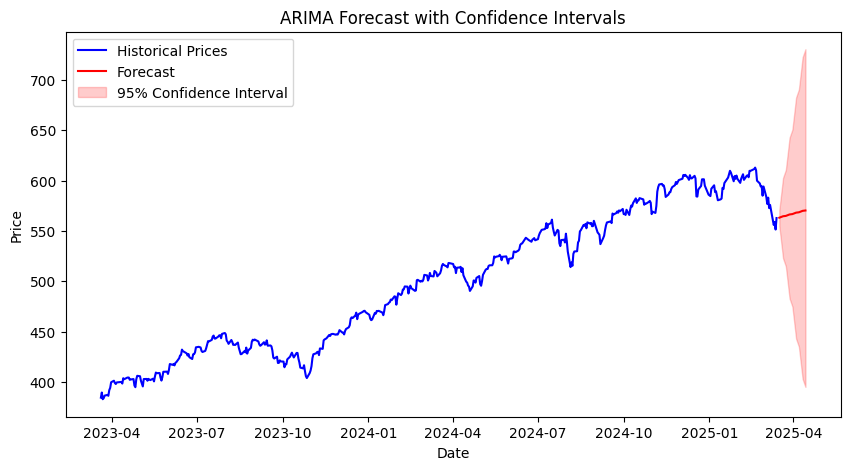

In [39]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller


# Function to check stationarity using the ADF test
def check_stationarity(data):
    result = adfuller(data.dropna())  # Drop NaN values before ADF test
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] > 0.05:
        print("Data is not stationary. Apply differencing or transformations.")
        return False
    else:
        print("Data is stationary.")
        return True

# Function to fit the ARIMA model
def fit_arima_model(stock_data):
    warnings.filterwarnings("ignore")
    # Check for stationarity
    is_stationary = check_stationarity(stock_data['Close'])

    # Apply differencing if data is not stationary
    if not is_stationary:
        stock_data['Close_diff'] = stock_data['Close'].diff().dropna()  # Drop NaN values after differencing
        print("Applied differencing to make data stationary.")
        data_to_fit = stock_data['Close_diff']
        data_to_fit.dropna(inplace=True)  # Drop NaN values after differencing
    else:
        data_to_fit = stock_data['Close']

    # Fit ARIMA model using auto_arima
    auto_model = auto_arima(
        data_to_fit,
        seasonal=False,
        stepwise=True,
        trace=True,
        information_criterion='aic'
    )

    # Get the best ARIMA order
    p, d, q = auto_model.order
    print(f"Best ARIMA Order: p={p}, d={d}, q={q}")

    # Fit ARIMA model
    model = ARIMA(data_to_fit, order=(p, d, q))
    arima_result = model.fit()
    print(f"ARIMA Forecast (Auto-Selected p={p}, d={d}, q={q})")
    return arima_result

# Function to test ARIMA forecasts
def test_arima_forecasts(stock_data, forecast_steps=21):
    # Fit ARIMA model and forecast with confidence intervals
    arima_result = fit_arima_model(stock_data)

    # Get forecast and confidence intervals correctly
    forecast_obj = arima_result.get_forecast(steps=forecast_steps)
    forecast = forecast_obj.predicted_mean  # Forecasted values
    conf_int = forecast_obj.conf_int()      # Confidence intervals

    # Convert differenced forecast back to actual prices
    last_actual_price = stock_data['Close'].iloc[-1]  # Last known actual price
    forecast_prices = np.cumsum(forecast) + last_actual_price  # Reverse differencing

    # Compute confidence interval bounds for actual prices
    lower_bound = np.cumsum(conf_int.iloc[:, 0] - forecast.iloc[0]) + last_actual_price
    upper_bound = np.cumsum(conf_int.iloc[:, 1] - forecast.iloc[0]) + last_actual_price

    # Print forecasted values and confidence intervals
    forecast_df = pd.DataFrame({
        "Forecasted Price": forecast_prices,
        "Lower Bound (95%)": lower_bound,
        "Upper Bound (95%)": upper_bound
    })
    print("\nForecasted Prices with Confidence Intervals:\n")
    print(forecast_df)

    # Plot results with error bars
    plt.figure(figsize=(10, 5))
    plt.plot(stock_data['Close'], label="Historical Prices", color="blue")
    plt.plot(pd.date_range(stock_data.index[-1], periods=forecast_steps + 1, freq="B")[1:],
             forecast_prices, label="Forecast", color="red")

    # Add confidence intervals as shaded area
    plt.fill_between(pd.date_range(stock_data.index[-1], periods=forecast_steps + 1, freq="B")[1:],
                     lower_bound, upper_bound, color='red', alpha=0.2, label="95% Confidence Interval")

    plt.legend()
    plt.title("ARIMA Forecast with Confidence Intervals")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.show()

# Example usage:
# stock_data = pd.read_csv("your_stock_data.csv", index_col="Date", parse_dates=True)
# test_arima_forecasts(stock_data, forecast_steps=21)

test_arima_forecasts(stock_data)

In [35]:
stock_data.name

'SPY'

In [40]:
from tqdm import tqdm  # Import tqdm for the progress bar

import pandas as pd

def precompute_arima_forecasts(stock_data, lookback_period=252, forecast_steps=21):
    # Initialize lists to store forecasts, confidence intervals, and levels
    forecasts = []
    conf_intervals = []

    # Precompute forecasts with a progress bar
    for i in tqdm(range(lookback_period, len(stock_data)), desc="Precomputing ARIMA Forecasts"):
        # Extract the rolling window data
        window_data = stock_data.iloc[i - lookback_period:i]

        arima_result = fit_arima_model(window_data)
        forecast = arima_result.get_forecast(steps=forecast_steps)
        forecasted_values = forecast.predicted_mean
        conf_int = forecast.conf_int()  # Confidence intervals

        # Append results to lists
        forecasts.append(forecasted_values.values)
        conf_intervals.append(conf_int.values)

    # Create a DataFrame to store the results
    results = pd.DataFrame({
        'Date': stock_data.index[lookback_period:],
        'Forecast': forecasts,
        'Confidence_Interval_Lower': [x[0][0] for x in conf_intervals],
        'Confidence_Interval_Upper': [x[0][1] for x in conf_intervals],
    })

    # Save the results to a CSV file
    results.to_csv(f'{stock_data.name}_arima_forecasts.csv', index=False)

precompute_arima_forecasts(stock_data=stock_data)

Precomputing ARIMA Forecasts:   0%|          | 0/247 [00:00<?, ?it/s]

ADF Statistic: -0.17560806297295078
p-value: 0.9413673035389506
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1307.674, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1304.986, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1305.826, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1305.527, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1306.341, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1300.864, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1302.329, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1302.149, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1302.810, Time=0.10 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.619 seconds
Best ARIMA Order: p=0, d=0, q=0


Precomputing ARIMA Forecasts:   0%|          | 1/247 [00:00<02:57,  1.39it/s]

ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.06624720552932103
p-value: 0.9636796315147345
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1306.455, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1304.685, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1304.807, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1304.337, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1305.264, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1304.406, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1306.392, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1301.253, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1300.588, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1301.584, Time=0.06 sec


Precomputing ARIMA Forecasts:   1%|          | 2/247 [00:01<03:16,  1.24it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1301.933, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.762 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.15100757149885785
p-value: 0.9693759468686095
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.839, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.736, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.583, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1300.100, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1301.064, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1300.420, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1302.416, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.209, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   :

Precomputing ARIMA Forecasts:   1%|          | 3/247 [00:02<03:36,  1.13it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1296.881, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.890 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.10634334310298822
p-value: 0.9664915244503867
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.870, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.726, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.646, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1300.164, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1301.073, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1300.394, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1302.390, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.448, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   :

Precomputing ARIMA Forecasts:   2%|▏         | 4/247 [00:03<03:35,  1.13it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1297.061, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.783 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: -0.014656848652058078
p-value: 0.9573030598481098
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.438, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.309, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.233, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1299.757, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1300.751, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1300.031, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1302.013, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.388, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept  

Precomputing ARIMA Forecasts:   2%|▏         | 5/247 [00:04<03:39,  1.10it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1297.092, Time=0.16 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.846 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.0947901312443333
p-value: 0.965703586815412
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1302.417, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1300.346, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1300.237, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1299.744, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1300.698, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1299.937, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1301.914, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1296.543, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : A

Precomputing ARIMA Forecasts:   2%|▏         | 6/247 [00:05<03:29,  1.15it/s]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1297.230, Time=0.08 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.659 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.30705202938411413
p-value: 0.9776657258940108
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1304.053, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1302.072, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1301.939, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1301.425, Time=0.54 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1302.347, Time=0.68 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1301.592, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1303.574, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1297.739, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   :

Precomputing ARIMA Forecasts:   3%|▎         | 7/247 [00:08<06:23,  1.60s/it]

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1298.369, Time=0.42 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.962 seconds
Best ARIMA Order: p=0, d=0, q=0
ARIMA Forecast (Auto-Selected p=0, d=0, q=0)
ADF Statistic: 0.45507728113882157
p-value: 0.9834418185818515
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1301.457, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1299.024, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1299.110, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1298.585, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1299.300, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1298.218, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1300.190, Time=0.15 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1300.148, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             :

Precomputing ARIMA Forecasts:   3%|▎         | 8/247 [00:10<06:55,  1.74s/it]

 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1297.050, Time=0.23 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.936 seconds
Best ARIMA Order: p=0, d=0, q=2
ARIMA Forecast (Auto-Selected p=0, d=0, q=2)
ADF Statistic: 0.44766684856587974
p-value: 0.9831926117178932
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1300.427, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1298.591, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1298.863, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1298.366, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1299.021, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1297.857, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1299.836, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1299.805, Time=0.05 sec
 ARIMA(1,0,3)(0,0,0)[0]             :

Precomputing ARIMA Forecasts:   4%|▎         | 9/247 [00:12<07:13,  1.82s/it]

 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=1296.899, Time=0.25 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.905 seconds
Best ARIMA Order: p=0, d=0, q=2
ARIMA Forecast (Auto-Selected p=0, d=0, q=2)
ADF Statistic: 0.20622189820884848
p-value: 0.9726084101042398
Data is not stationary. Apply differencing or transformations.
Applied differencing to make data stationary.
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1299.485, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1296.628, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1296.975, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1296.527, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1297.301, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=1296.218, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1298.191, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=1298.150, Time=0.05 sec


Precomputing ARIMA Forecasts:   4%|▎         | 9/247 [00:13<05:54,  1.49s/it]

 ARIMA(1,0,3)(0,0,0)[0]             : AIC=inf, Time=0.45 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1292.632, Time=0.10 sec


KeyboardInterrupt: 

In [64]:
import backtrader as bt
import pandas as pd
import yfinance as yf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import warnings

# 📌 Step 2: Backtrader Strategy with Dynamic Data Access
class RollingARIMAStrategy(bt.Strategy):
    params = (
        ('lookback_period', 252),  # Default lookback period (1 year of trading days)
        ('forecast_steps', 21),  # Forecast 1 day ahead
    )

    def __init__(self):
        self.data_close = self.data.close  # Access closing prices

    def next(self):
        # Print progress
        print(f"Step: {len(self.data_close)} | Portfolio Value: {self.broker.getvalue():.2f}")
        # Check if we have enough data for the lookback period

        if len(self.data_close) > self.params.lookback_period:
            # Extract the most recent `lookback_period` data points
            window_data = self.data_close.get(size=self.params.lookback_period)

            # Convert window_data to a pandas Series
            window_data = pd.Series(window_data)

            arima_result = fit_arima_model(window_data)

            # Forecast the next `forecast_steps` days
            forecast = arima_result.forecast(steps=self.params.forecast_steps)
            forecasted_price = forecast.max()  # Get the forecasted price

            # Trading logic
            current_price = self.data_close[0]
            if forecasted_price > current_price:
                self.buy()  # Buy signal
            elif forecasted_price < current_price:
                self.sell()  # Sell signal

    def notify_trade(self, trade):
        # Print trade details when a trade is opened or closed
        if trade.isclosed:
            print(f"TRADE CLOSED: {trade.data._name} | PnL: {trade.pnl:.2f} | Commission: {trade.commission:.2f}")
        elif trade.justopened:
            print(f"TRADE OPENED: {trade.data._name} | Size: {trade.size} | Price: {trade.price:.2f}")

    def notify_order(self, order):
        # Print order details when an order is executed
        if order.status in [order.Completed, order.Canceled, order.Margin]:
            print(f"ORDER EXECUTED: {order.data._name} | Size: {order.size} | Price: {order.executed.price:.2f}")

# 📌 Step 3: Backtest the Strategy
if __name__ == '__main__':
    # Create a Cerebro engine instance
    cerebro = bt.Cerebro()

    # Add the strategy to Cerebro with custom parameters
    cerebro.addstrategy(
        RollingARIMAStrategy,
        lookback_period=252,  # 1 year of trading days
        forecast_steps=1  # Forecast 1 day ahead
    )

    # Prepare the data for Backtrader
    stock_data.reset_index(inplace=True)
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data.set_index('Date', inplace=True)
    data = bt.feeds.PandasData(dataname=stock_data)

    # Add the data to Cerebro
    cerebro.adddata(data)

    # Set the initial cash
    cerebro.broker.set_cash(10000.0)

    # Set the commission (optional)
    cerebro.broker.setcommission(commission=0.001)

    # Run the backtest
    print("Starting Portfolio Value: %.2f" % cerebro.broker.getvalue())
    cerebro.run()
    print("Final Portfolio Value: %.2f" % cerebro.broker.getvalue())

    # Plot the results
    cerebro.plot()

Starting Portfolio Value: 10000.00
Step: 1 | Portfolio Value: 10000.00
Step: 2 | Portfolio Value: 10000.00
Step: 3 | Portfolio Value: 10000.00
Step: 4 | Portfolio Value: 10000.00
Step: 5 | Portfolio Value: 10000.00
Step: 6 | Portfolio Value: 10000.00
Step: 7 | Portfolio Value: 10000.00
Step: 8 | Portfolio Value: 10000.00
Step: 9 | Portfolio Value: 10000.00
Step: 10 | Portfolio Value: 10000.00
Step: 11 | Portfolio Value: 10000.00
Step: 12 | Portfolio Value: 10000.00
Step: 13 | Portfolio Value: 10000.00
Step: 14 | Portfolio Value: 10000.00
Step: 15 | Portfolio Value: 10000.00
Step: 16 | Portfolio Value: 10000.00
Step: 17 | Portfolio Value: 10000.00
Step: 18 | Portfolio Value: 10000.00
Step: 19 | Portfolio Value: 10000.00
Step: 20 | Portfolio Value: 10000.00
Step: 21 | Portfolio Value: 10000.00
Step: 22 | Portfolio Value: 10000.00
Step: 23 | Portfolio Value: 10000.00
Step: 24 | Portfolio Value: 10000.00
Step: 25 | Portfolio Value: 10000.00
Step: 26 | Portfolio Value: 10000.00
Step: 27 | P

KeyboardInterrupt: 